# Training quantum embedding kernels for classification

In this tutorial we will dive deeper into the the concept of quantum embedding kernels, or quantum kernels. We will train a quantum kernel based on a similarity measure called the kernel-target alignment and see how the training improves the performance of it as a classifier. We will demonstrate how to use Covalent to orchestrate the whole workflow composed of multiple smaller subtasks. Once the workflow is dispatched, we will be able to track the results of each subtask through the Covalent result manager. In the meantime, all the subtasks constructed can be called as normal Python functions, giving users more flexibility in testing and debugging. For more details about the quantum embedding kernels, we refer the reader to this PennyLane demo: [Training and evaluating quantum kernels](https://pennylane.ai/qml/demos/tutorial_kernels_module.html#training-qeks), which this tutorial is based on.

In addition to Covalent, one first needs to install the following packages in order to fully reproduce the results of this tutorial.

In [ ]:
# !pip install pennylane==0.23.1
# !pip install scikit-learn==1.1.1
# !pip install matplotlib==3.5.1
# !pip install covalent-dask-plugin

Let us begin by starting the Covalent server and importing the necessary packages.

In [12]:
# !covalent start

In [2]:
import pennylane as qml
from pennylane import numpy as np
import covalent as ct
from covalent.executor import DaskExecutor
from dask.distributed import LocalCluster
import matplotlib.pyplot as plt
from matplotlib.colors import ListedColormap
from matplotlib.markers import MarkerStyle
from sklearn.datasets import make_classification
from sklearn.model_selection import train_test_split
from sklearn.svm import SVC
from sklearn.inspection import DecisionBoundaryDisplay

cluster = LocalCluster(processes=True)
dask_executor = DaskExecutor(scheduler_address=cluster.scheduler_address)

np.random.seed(2022)

/Users/ruihaoli/opt/miniconda3/lib/python3.8/site-packages/distributed/node.py:160: UserWarning: Port 8787 is already in use.
Perhaps you already have a cluster running?
Hosting the HTTP server on port 61530 instead
  warnings.warn(


## Defining the quantum kernel

We first generate a dataset with two features and two classes for our classification task using `scikit-learn`'s `make_classification` function. For this tutorial, we will make the dataset contain 20 randomly generated points, with 10 in each class. We then do a train/test split with ratio 7:3. Moreover, we include the above two steps in the Covalent workflow as subtasks by adding the `electron` decorator on top of the respective functions.

In [3]:
@ct.electron
def get_data(n_samples=20):
    X, y = make_classification(
        n_samples=n_samples, n_features=2, n_redundant=0, random_state=42, n_clusters_per_class=2, flip_y=0.3, class_sep=0.5
    )
    X = X.astype(np.float32)
    y = 2 * (y - 0.5) # rescale labels to be -1, 1
    y = y.astype(int)
    return X, y

@ct.electron
def split_train_test_data(X, y, test_size=0.3):
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=test_size, random_state=5)
    return X_train, X_test, y_train, y_test

As mentioned in the beginning, these subtasks can be called as normal Python functions. So we can plot the dataset for visualization.

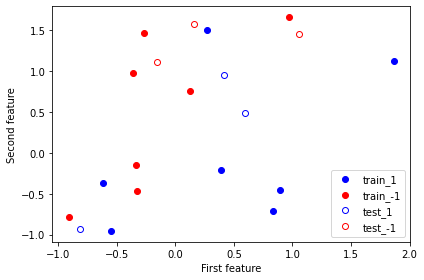

In [4]:
X, y = get_data()
X_train, X_test, y_train, y_test = split_train_test_data(X, y)

fig, ax = plt.subplots(1, 1, figsize=(6, 4), facecolor="w")
ax.plot(X_train[:, 0][y_train==1], X_train[:, 1][y_train==1], "bo", label="train_1")
ax.plot(X_train[:, 0][y_train==-1], X_train[:, 1][y_train==-1], "ro", label="train_-1")
ax.plot(X_test[:, 0][y_test==1], X_test[:, 1][y_test==1], "bo", fillstyle='none', label="test_1")
ax.plot(X_test[:, 0][y_test==-1], X_test[:, 1][y_test==-1], "ro", fillstyle='none', label="test_-1")
ax.set_xlabel("First feature")
ax.set_ylabel("Second feature")
plt.tight_layout()
plt.legend(loc="lower right")
plt.show()

Next, we construct the quantum embedding kernel by building a *data reuploading* quantum circuit based on the ansatz given in [Hubregtsen et al. 2021](https://arxiv.org/abs/2105.02276). Specifically, this ansatz uses a repeating layer architecture, where each layer embeds the 2 features into 5 qubits through the angles of $R_Z$ gates. The variational parameters correspond to the angles of a series of $R_Y$ and controlled-$R_Z$ gates. The ansatz diagram of one layer is shown below.

<div align="center">
<img src="././qek_images/qek_circuit.png" style="width: 50%; height: 50%"/>
</div>

A quantum kernel is given by the mutual overlap of the two data-embedding quantum states, i.e.,
$$
k(x_1, x_2) = \vert{\langle \phi(x_2) \vert \phi(x_1) \rangle} \vert^2.
$$
Therefore, to define a quantum kernel function, we construct the following subtasks with Covalent:
- `layer` - Build the quantum circuit for each layer of the ansatz.
- `ansatz` - Construct the ansatz circuit with an arbitrary number of layers.
- `adjoint_ansatz` - Get the adjoint of the ansatz circuit.
- `kernel_circuit` - Construct the quantum embedding kernel circuit based on `ansatz` and `adjoint_ansatz`.
- `kernel` - Return the quantum kernel function based on `kernel_circuit`.

In [5]:
@ct.electron
def layer(x, params, wires, i0=0, inc=1):
    i = i0
    for j, wire in enumerate(wires):
        qml.Hadamard(wires=[wire])
        qml.RZ(x[i % len(x)], wires=[wire])
        i += inc
        qml.RY(params[0, j], wires=[wire])

    qml.broadcast(unitary=qml.CRZ, pattern="ring", wires=wires, parameters=params[1])

@ct.electron
def ansatz(x, params, wires):
    for j, layer_params in enumerate(params):
        layer(x, layer_params, wires, i0=j * len(wires))

@ct.electron
def adjoint_ansatz(ansatz):
    return qml.adjoint(ansatz)

@ct.electron
def kernel_circuit(params):
    dev = qml.device("default.qubit", wires=params.shape[2], shots=None) # number of wires corresponds to the third dimension of params
    wires = dev.wires.tolist()
    @qml.qnode(dev)
    def circuit(x1, x2, params):
        ansatz(x1, params, wires=wires)
        adjoint_ansatz(ansatz)(x2, params, wires=wires)
        return qml.probs(wires=wires)
    return circuit

@ct.electron
def kernel(x1, x2, params):
    return kernel_circuit(params)(x1, x2, params)[0]

Now we are in a position to build a support vector machine (SVM) classifier based on the quantum kernel and evaluate the accuracy of its predictions. It consists of three subtasks:
- `init_params` - Randomly initialize the variational parameters.
- `svm` - Build the SVM classifier using the quantum kernel.
- `get_accuracy` - Evaluate the accuracy of the classifier on a given dataset.

To accomplish the second subtask, we first use PennyLane's `qml.kernels.kernel_matrix` function to get the kernel matrix of a full dataset (not just between two data points) based on the given parameters. The kernel matrix is then fed into `scikit-learn`'s support vector classifier (`SVC`), which allows us to build a quantum SVM estimator using the training data.

In [6]:
@ct.electron
def init_params(num_wires, num_layers):
    return np.random.uniform(0, 2 * np.pi, (num_layers, 2, num_wires), requires_grad=True)

@ct.electron
def svm(X, y, params):
    kernel_input = lambda x1, x2: kernel(x1, x2, params)
    svm = SVC(kernel=lambda x1, x2: qml.kernels.kernel_matrix(x1, x2, kernel_input))
    svm.fit(X, y)
    return svm

@ct.electron
def calc_accuracy(classifier, X, y_true):
    return 1 - np.count_nonzero(classifier.predict(X) - y_true) / len(y_true)   

Finally, we can combine all the subtasks discussed above into a single workflow function called `init_qsvm` with the `lattice` decorator on top. For this tutorial, we will be using 3 layers of the embedding ansatz.

In [7]:
@ct.lattice(executor=dask_executor)
def init_qsvm(n_samples=20, num_wires=5, num_layers=3):
    X, y = get_data(n_samples)
    X_train, X_test, y_train, y_test = split_train_test_data(X, y)
    params = init_params(num_wires, num_layers)
    classifier = svm(X_train, y_train, params)
    train_acc = calc_accuracy(classifier=classifier, X=X_train, y_true=y_train)
    test_acc = calc_accuracy(classifier=classifier, X=X_test, y_true=y_test)
    return classifier, X_train, y_train, X_test, y_test, train_acc, test_acc

The workflow is then dispatched to the Covalent server and the results are retrievable once the workflow is finished. One can also track all the results through the Covalent result manager.

In [108]:
dispatch_id = ct.dispatch(init_qsvm)(20, 5, 3)
result = ct.get_result(dispatch_id=dispatch_id, wait=True)
qsvm, X_train, y_train, X_test, y_test, train_acc, test_acc = result.result

In [109]:
print(f"Train accuracy: {train_acc}")
print(f"Test accuracy: {test_acc}")

Train accuracy: 0.8571428571428572
Test accuracy: 0.5


Furthermore, we can also plot the decision boundaries of our initial SVM classifier for better visualization.

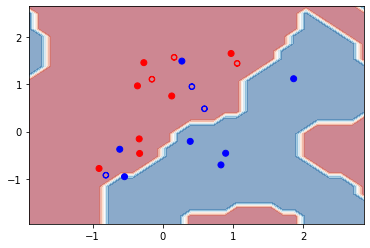

In [110]:
cm = plt.cm.RdBu
cm_bright = ListedColormap(['#FF0000', '#0000FF'])

disp = DecisionBoundaryDisplay.from_estimator(qsvm, X, grid_resolution=30, response_method='predict', alpha=0.5, cmap=cm)
disp.ax_.scatter(X_train[:, 0], X_train[:, 1], c=y_train, cmap=cm_bright)
disp.ax_.scatter(X_test[:, 0], X_test[:, 1], c=y_test, cmap=cm_bright, marker="$\u25EF$")
plt.show()

We see that our initial SVM classifier based on a random set of parameters is not very accurate, particularly on the test set. The accuracy is about 86% on the train set, while on the test set it is only 50%. In the next section, we will train the quantum kernel to find a better set of parameters which will hopefully improve the accuracy of the classifier.

## Training the quantum kernel

The *kernel alignment* is a similarity measure between two kernels with kernel matrices $K_1$ and $K_2$, which is defined as
$$
\text{KA}(K_1, K_2)\equiv \frac{\text{Tr}(K_1 K_2)}{\sqrt{\text{Tr}(K_1^2) \text{Tr}(K_2^2)}}.
$$
We will train the quantum SVM classifier by optimizing the *kernel-target alignment*, which compares the similarity predicted by the quantum kernel to the actual labels of the training data. In particular, any two training data points define an ideal kernel function given by
$$
k_{\textbf{y}}(\textbf{x}_i, \textbf{x}_j) = y_i y_j,
$$
where $y_{i,j}$ are the labels associated with the data points $\textbf{x}_{i,j}$. The assigned kernel is thus $+1$ if both data points are in the same class and $-1$ if they belong to different classes. Then the kernel matrix is given by the outer product $\textbf{y}\textbf{y}^T$. The kernel-target alignment is therefore defined as the kernel alignment of the kernel matrix $K$ generated by the quantum kernel and the ideal kernel matrix $\textbf{y}\textbf{y}^T$:
$$
\text{KTA}_{\textbf{y}}(K) = \frac{\text{Tr}(K_1 \textbf{y}\textbf{y}^T)}{\sqrt{\text{Tr}(K^2) \text{Tr}((\textbf{y}\textbf{y}^T)^2)}}.
$$
The training then aims to find an optimal set of variational parameters that maximizes the kernel-target alignment.

In the following, we will construct three subtasks as `electron` in Covalent for training the quantum embedding kernel:
- `target_alignment` - Compute the kernel-target alignment of the quantum kernel for a given dataset.
- `get_optimizer` - Get the optimizer used for optimizing the kernel-target alignment. Here we choose the `AdagradOptimizer` from PennyLane.
- `training` - Train the quantum embedding kernel by optimizing the kernel-target alignment.

In [8]:
@ct.electron
def target_alignment(
    X,
    Y,
    kernel,
    assume_normalized_kernel=False,
    rescale_class_labels=True,
):
    K = qml.kernels.square_kernel_matrix(
        X,
        kernel,
        assume_normalized_kernel=assume_normalized_kernel,
    )

    if rescale_class_labels:
        nplus = np.count_nonzero(np.array(Y) == 1)
        nminus = len(Y) - nplus
        _Y = np.array([y / nplus if y == 1 else y / nminus for y in Y])
    else:
        _Y = np.array(Y)

    T = np.outer(_Y, _Y)
    inner_product = np.sum(K * T)
    norm = np.sqrt(np.sum(K * K) * np.sum(T * T))
    inner_product = inner_product / norm

    return inner_product

@ct.electron
def get_optimizer():
    return qml.AdagradOptimizer(0.4)

@ct.electron
def training(X, Y, init_params, opt, steps=400):
    params = init_params
    KTAs = []
    for i in range(steps):
        # Randomly choose subset of data points to compute the KTA on.
        subset = np.random.choice(list(range(len(X))), 5)
        # Define the cost function for optimization
        cost = lambda _params: -target_alignment(
            X[subset],
            Y[subset],
            lambda x1, x2: kernel(x1, x2, _params),
            assume_normalized_kernel=True,
        )
        # Optimization step
        params = opt.step(cost, params)
        KTAs.append(target_alignment(X, Y, lambda x1, x2: kernel(x1, x2, params),
                assume_normalized_kernel=True,))

    return params, KTAs

In [9]:
@ct.lattice(executor=dask_executor)
def trained_qsvm(n_samples=20, num_wires=5, num_layers=3, steps=400):
    X, y = get_data(n_samples)
    X_train, X_test, y_train, y_test = split_train_test_data(X, y)
    params = init_params(num_wires, num_layers)
    opt = get_optimizer()
    opt_params, KTAs = training(X_train, y_train, params, opt, steps)
    opt_classifier = svm(X_train, y_train, opt_params)
    train_acc = calc_accuracy(classifier=opt_classifier, X=X_train, y_true=y_train)
    test_acc = calc_accuracy(classifier=opt_classifier, X=X_test, y_true=y_test)
    return opt_classifier, KTAs, X_train, y_train, X_test, y_test, train_acc, test_acc

In [ ]:
dispatch_id = ct.dispatch(trained_qsvm)(20, 5, 3, 400)
result = ct.get_result(dispatch_id=dispatch_id, wait=True)
opt_qsvm, KTAs, X_train, y_train, X_test, y_test, train_acc, test_acc = result.result

In [13]:
result = ct.get_result(dispatch_id=dispatch_id, wait=False)